In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import lightgbm as lgb
import itertools
import time
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [12]:
path = "/content/drive/MyDrive/projects/titanic/"

df_train = pd.read_csv(path+"data/train_add_f.csv")
df_test = pd.read_csv(path+"data/test_add_f.csv")

df = pd.concat([df_train, df_test], sort=False)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,0
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1


In [13]:
conf = json.load(open(path + "config/config_lgbm.json"))

target = conf["target"]
features = conf["features"]
delete_columns = conf["delete_columns"]

df.drop(delete_columns, axis=1, inplace=True)
train = df[:len(df_train)]
test = df[len(df_train):]
y_train = train[target]
x_train = train.drop(target, axis=1)
x_test = test.drop(target, axis=1)

In [14]:
all_params = [
              dict(zip(conf["cv_params"].keys(), v))
              for v in itertools.product(*conf["cv_params"].values())
]
print(len(all_params))

144


In [15]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
categorical_features = conf["categorical_features"]

best_score = 1000000
best_params = {}
best_y_preds = []
best_feature_importances = []

start = time.time()
# パラメータの組み合わせごとに交差検証
for params in tqdm(all_params):
  models = []
  y_preds = [] # 各交差検証でのテストデータの予測結果
  for fold_id, (train_index, valid_index) in enumerate(cv.split(x_train)):
      x_tr = x_train.loc[train_index, :]
      x_val = x_train.loc[valid_index, :]
      y_tr = y_train[train_index]
      y_val = y_train[valid_index]
      
      # lightgbm用のデータセットを作成
      lgb_train = lgb.Dataset(x_tr, y_tr, categorical_feature=categorical_features)
      lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train, categorical_feature=categorical_features)

      # num_leavesのパラメータを作成
      if "num_leaves_rate" in conf["cv_params"]:
          val_params = {**conf["params"], **params}
          val_params["num_leaves"] = int((2**val_params["max_depth"]) * val_params["num_leaves_rate"])
          del val_params["num_leaves_rate"]

      model = lgb.train(
          val_params, lgb_train,
          valid_sets=[lgb_train, lgb_eval],
          verbose_eval=0,
          num_boost_round=1000,
          early_stopping_rounds=10
      )
      y_pred = model.predict(x_test, num_iteration=model.best_iteration)
      y_preds.append(y_pred)
      models.append(model)
    
  # このparamsでの交差検証の平均スコアを出す
  scores = [m.best_score["valid_1"][conf["loss"]] for m in models]
  score = sum(scores) / len(scores)
  if score < best_score:
    best_score = score
    best_params = params
    # テストでの予測
    y_sub = sum(y_preds) / len(y_preds)
    best_y_preds = (y_sub > 0.5).astype(int)
    best_feature_importances = model.feature_importance(importance_type='gain')

100%|██████████| 144/144 [16:28<00:00,  6.87s/it]


In [16]:
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:988.7899420261383[sec]


In [17]:
print(best_score)
print(best_params)

0.4229902081507763
{'max_bin': 150, 'num_leaves_rate': 0.7, 'boosting': 'gbdt', 'max_depth': 5}


In [19]:
df_sub = pd.read_csv(path+"data/gender_submission.csv")
df_sub["Survived"] = best_y_preds[0]

In [ ]:
#df_sub.to_csv(path+"data/submission.csv", index=False)

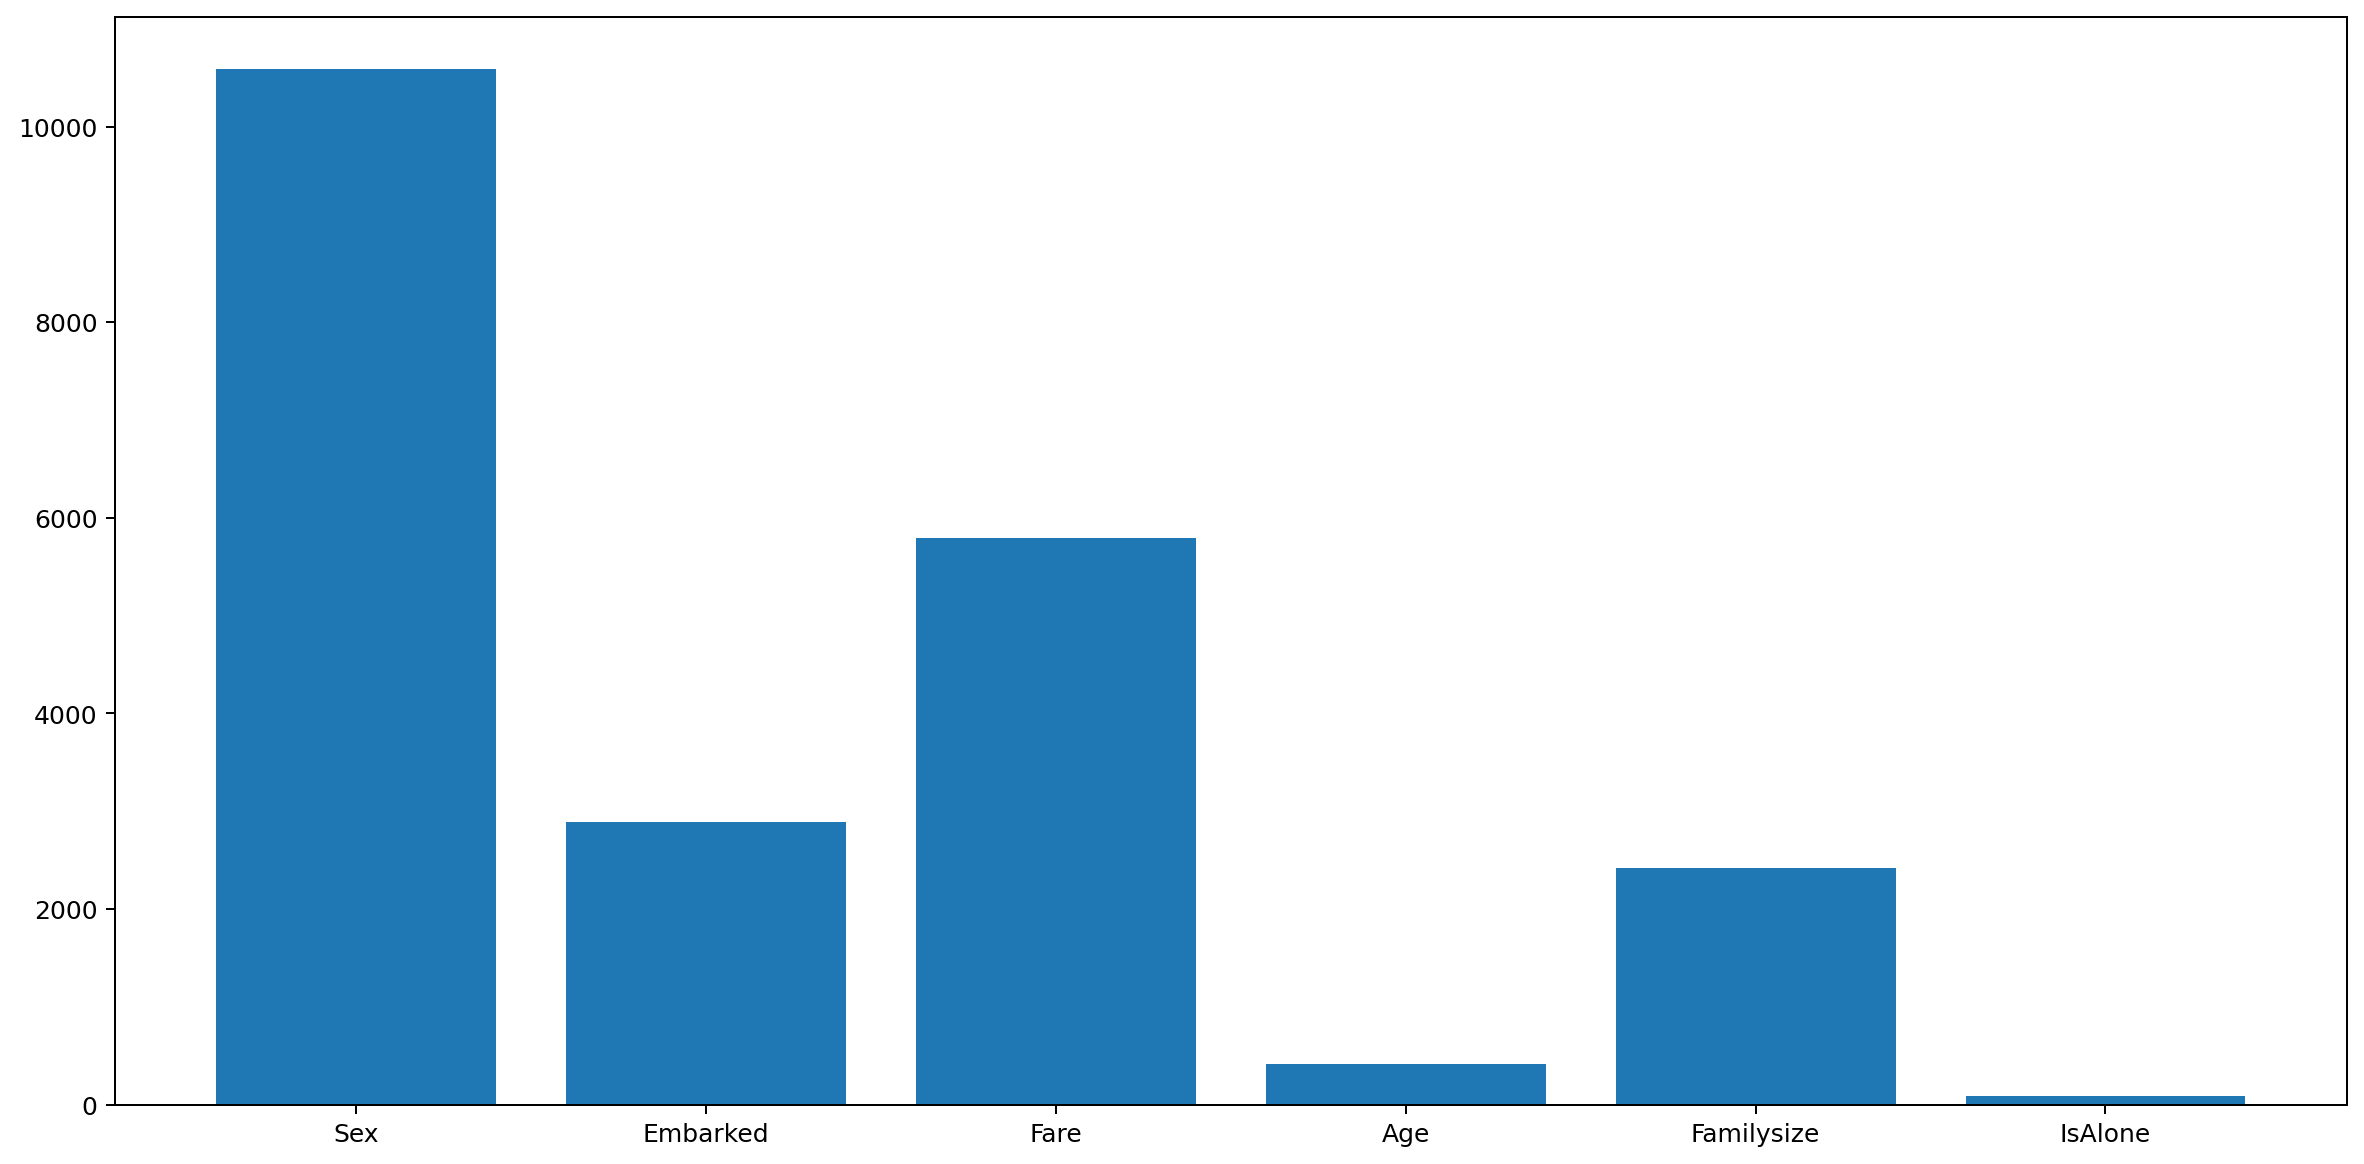

In [21]:
fig, ax = plt.subplots(figsize=(16, 8), dpi=180)
ax.bar(conf["features"], best_feature_importances)
plt.show()
plt.close()